### Анализ временной статистики работы ассессоров

**Задача:** Определить справедливое вознаграждение ассессора за выполнение одного микрозадания. Ассессор за 30 секунд своего времени получает **N** рублей

 #### Описание данных:
 1. login — логин асессора
 2. tid — id оцениваемого задания
 3. microtasks – количество микрозаданий в одном задании
 4. assigned_ts — время резервирования системой задания для асессора
 5. closed_ts — точное время завершения работы над заданием

### План работы
1. Подсчитаем время выполнения таски в секундах 
2. Предобработаем предложенные данные:
    * Удалим полные дубликаты
    * Преобразовываем типы данных
3. Найдем время выполнения задания в разрезе микротаска для каждой записи
4. Оценим по диаграмме размаха диапазон распределения значений выполнения микротаски в секундах. Определяем максимальное пороговое значение для выполнения микротаски - 500 секунд, предполагая, что если асессору понадобилось более 500 секунд на выполнение, то скорее всего он отвлекался или не сразу приступил к выполнению. Все записи с временем выполнения более 500 секунд и менее 0 не учитываем.
5. Медианное значение времени выполнения микротаски - **64 секунды**, при условии, что асессор получает N рублей за 30 секунд, следовательно, справедливое вознаграждение асессору за выполнение 1 микротаски составляет **2.13*N**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
df = pd.read_table('data_task4_old.txt', sep = '\t')
df.head(5)

login          tid  Microtasks          assigned_ts            closed_ts
0  login0  190563850.0         4.0  2017-04-20 12:09:39  2017-04-20 13:13:01
1  login0  190561754.0         1.0  2017-04-20 12:10:30  2017-04-20 12:28:29
2  login0  190565906.0         4.0  2017-04-20 12:21:31  2017-04-20 13:30:10
3  login0  190560246.0         1.0  2017-04-20 12:28:30  2017-04-20 13:13:56
4  login0  190562168.0         2.0  2017-04-20 12:28:42  2017-04-20 13:14:50

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   login        701827 non-null  object 
 1   tid          701827 non-null  float64
 2   Microtasks   701827 non-null  float64
 3   assigned_ts  701827 non-null  object 
 4   closed_ts    701827 non-null  object 
dtypes: float64(2), object(3)
memory usage: 26.8+ MB


In [4]:
# Преобразование типов данных и замена регистра колонки `Microtasks`

df = df.rename(columns = {'Microtasks':'microtasks'})
df['assigned_ts'] = pd.to_datetime(df['assigned_ts'], format = '%Y-%m-%d %H:%M:%S')
df['closed_ts'] = pd.to_datetime(df['closed_ts'], format = '%Y-%m-%d %H:%M:%S')
df['microtasks'] = df['microtasks'].astype('int64')
df['tid'] = df['tid'].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701827 entries, 0 to 701826
Data columns (total 5 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   login        701827 non-null  object        
 1   tid          701827 non-null  int64         
 2   microtasks   701827 non-null  int64         
 3   assigned_ts  701827 non-null  datetime64[ns]
 4   closed_ts    701827 non-null  datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(1)
memory usage: 26.8+ MB


In [5]:
# Расчет времени задания и времени микрозадания

df['operation_time_sec'] = (df['closed_ts'] - df['assigned_ts']).dt.total_seconds()
df['microtask_sec'] = (df['operation_time_sec']/df['microtasks'])

In [6]:
# Проверка на дубликаты

df.duplicated().sum()

21790

In [7]:
df_good = df.drop_duplicates()

Text(0, 0.5, 'Секунды')

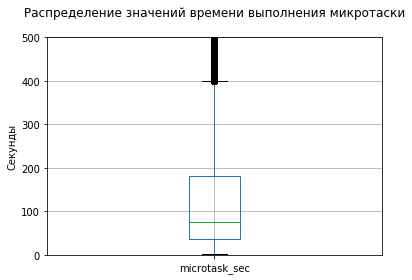

In [8]:
# Диграмма размаха

df_good.boxplot('microtask_sec')
plt.ylim(0, 500)
plt.title('Распределение значений времени выполнения микротаски' + '\n')
plt.ylabel('Секунды')

Text(0, 0.5, 'Частота')

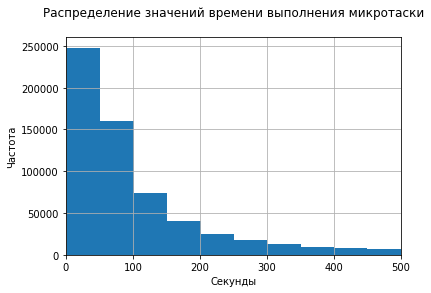

In [9]:
# Оставим данные без выбросов

df_good_500 = df_good.loc[(df_good['microtask_sec'] < 500)&(df_good['microtask_sec'] > 0)]
df_good_500
df_good_500['microtask_sec'].hist()
plt.xlim(0,500)
plt.title('Распределение значений времени выполнения микротаски' + '\n')
plt.xlabel('Cекунды')
plt.ylabel('Частота')

In [10]:
df_good_500.sort_values(['microtask_sec'], ascending = False)

login        tid  microtasks         assigned_ts  \
240470  login233  167764668           8 2017-05-05 22:30:47   
665048  login727  195247518          14 2017-05-12 19:12:54   
72379    login71  168006086           5 2017-05-14 08:15:50   
269201  login265  170271234           4 2017-05-28 21:06:44   
569462  login633  191289254           3 2017-04-27 08:01:27   
...          ...        ...         ...                 ...   
153207  login139  198396841          50 2017-06-01 01:24:08   
474137  login517  192276632           8 2017-04-27 08:40:29   
315281  login328  168095766           9 2017-05-11 16:06:02   
153221  login139  198396915          42 2017-06-01 01:34:21   
151272  login139  196400390          13 2017-05-20 17:20:02   

                 closed_ts  operation_time_sec  microtask_sec  
240470 2017-05-05 23:37:26              3999.0     499.875000  
665048 2017-05-12 21:09:32              6998.0     499.857143  
72379  2017-05-14 08:57:29              2499.0     499.800000  
269201 2017-05-28 21:40:03              1999.0     499.750000  
569462 2017-04-27 08:26:26              1499.0     499.666667  
...                    ...                 ...            ...  
153207 2017-06-01 01:25:48               100.0       2.000000  
474137 2017-04-27 08:40:45                16.0       2.000000  
315281 2017-05-11 16:06:19                17.0       1.888889  
153221 2017-06-01 01:35:38                77.0       1.833333  
151272 2017-05-20 17:20:25                23.0       1.769231  

[603287 rows x 7 columns]

In [11]:
# Сколько секунд занимает выполнение микротаски в среднем

df_good_500['microtask_sec'].median()

64.0

In [12]:
# Сколько получает асессор за выполнение микротаски

result = df_good_500['microtask_sec'].median()/30
result

2.1333333333333333